In [1]:
!pip install torch torchvision pennylane

In [2]:
import torch
import torch.nn as nn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import pandas as pd

Epoch [1/100], Loss: 0.0566
Epoch [11/100], Loss: 0.0008
Epoch [21/100], Loss: 0.0026
Epoch [31/100], Loss: 0.0024
Epoch [41/100], Loss: 0.0020
Epoch [51/100], Loss: 0.0018
Epoch [61/100], Loss: 0.0016
Epoch [71/100], Loss: 0.0014
Epoch [81/100], Loss: 0.0012
Epoch [91/100], Loss: 0.0010


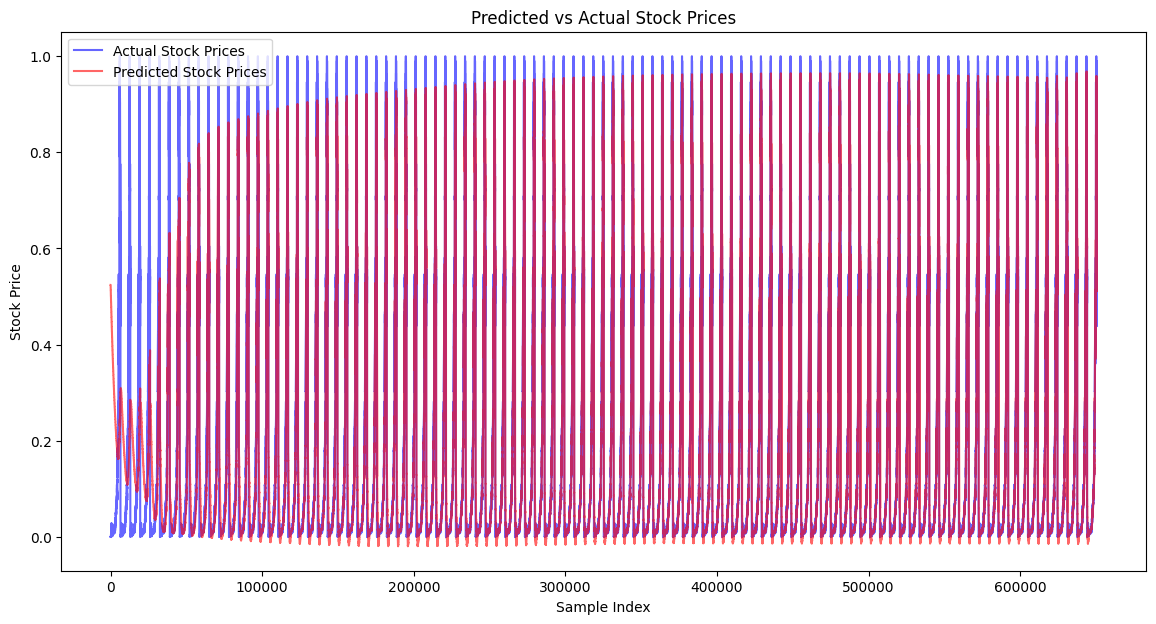

In [8]:

# Step 1: Load the CSV file (ensure the file path is correct)
file_path = 'AMZN.csv'  # Replace 'your_file.csv' with the actual file path
data = pd.read_csv(file_path)

# Assuming the stock prices are in a column named 'Close'
# If your column has a different name, change 'Close' accordingly
prices = data['Close'].values

# Step 2: Normalize the data
# (Min-Max scaling: Scale data between 0 and 1)
prices_normalized = (prices - np.min(prices)) / (np.max(prices) - np.min(prices))

# Step 3: Create sliding window data
def sliding_window_data(data, window_size):
    x = []
    y = []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return torch.Tensor(x), torch.Tensor(y)

# Use a sliding window of size 10 (for example)
window_size = 10
x_train, y_train = sliding_window_data(prices_normalized, window_size)

# Reshape x_train and y_train for LSTM input
x_train = x_train.unsqueeze(-1)  # Adding feature dimension for LSTM
y_train = y_train.unsqueeze(-1)  # Adding output dimension

# Step 4: Define the Quantum device
n_qubits = 4  # Number of qubits for quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Step 5: Define a quantum node (QNode)
@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# Step 6: Create the Quantum Neural Network (QNN) layer
weight_shapes = {"weights": (3, n_qubits)}
q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Step 7: Define the Hybrid Quantum LSTM model
class HybridQNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(HybridQNNLSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Quantum layer
        self.q_layer = q_layer

        # Fully connected layer for final prediction
        self.fc = nn.Linear(n_qubits, output_size)

    def forward(self, x):
        # LSTM output: (batch_size, seq_length, hidden_size)
        lstm_out, _ = self.lstm(x)

        # Take the last time-step output from LSTM
        lstm_out_last = lstm_out[:, -1, :]

        # Pass through Quantum layer
        qnn_out = self.q_layer(lstm_out_last)

        # Pass through Fully Connected layer to get final output
        output = self.fc(qnn_out)

        return output

# Step 8: Hyperparameters
input_size = 1           # Number of input features
hidden_size = 4          # Number of LSTM units
output_size = 1          # Predicted output size
num_layers = 1           # Number of LSTM layers
epochs = 100            # Number of training epochs
batch_size = 32          # Batch size for training

# Initialize the model
model = HybridQNNLSTM(input_size, hidden_size, output_size, num_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 9: Training the model
predictions = []  # To store model predictions
originals = []    # To store actual stock prices

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        # Get batch data
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        output = model(x_batch)
        loss = criterion(output, y_batch)

        # Store predictions and originals for plotting later
        predictions.append(output.detach().numpy())
        originals.append(y_batch.numpy())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 10: Plotting predictions vs actual prices
predictions = np.vstack(predictions)
originals = np.vstack(originals)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(originals, label='Actual Stock Prices', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted Stock Prices', color='red', alpha=0.6)
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import r2_score

# assuming you have two lists or arrays: y_true (actual) and y_pred (predicted)
r2 = r2_score(originals, predictions)
print(r2)


0.9329354166984558


In [10]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500
